[ 101.71848985    2.95602547   11.59297025 ...,   10.98872831  128.60287701
   13.31251243] (Unit not initialised) [ 8.23828051  2.53282975  3.99424636 ...,  1.9180775   8.90813593
  4.18269903] earthRad [  5.21353400e+06   9.54431800e+06   7.87247000e+06 ...,   2.12000000e+02
   2.79000000e+02   2.53000000e+02] [ 0.05781321  0.27139767  0.20855667 ...,  0.26081056  0.1020098   0.4465347 ] (25000,) (25000,) (25000,) (25000,)


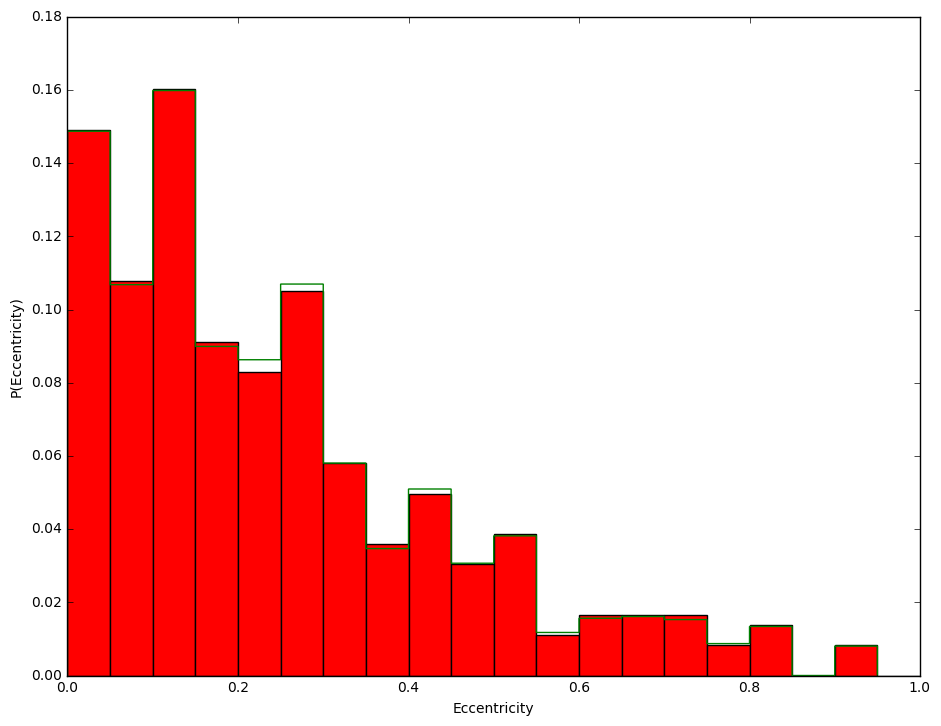

In [1]:
from astropy.table import QTable
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from astropy import constants as const

%matplotlib inline

# change the data for the kepler data, and graphs below
data = QTable.read('probecc_comma.dat',format='ascii.no_header')


data.rename_column('col1','ecc')
data.rename_column('col2','% in bin')
data.rename_column('col3','cum %')
x = np.arange(0,1,0.05)
y = data['cum %']
ecc_inbin = data['% in bin']
cum=data['cum %']
binwidth = 0.05
fig,ax=plt.subplots(1,1)
fig.set_size_inches(11,8.5)                  

bar = ax.bar(data['ecc'],ecc_inbin,width=0.05,color='r')
ax.set_xlabel('Eccentricity')
ax.set_ylabel('P(Eccentricity)')

n = 1
ecc_list = np.array([])
while n <= 25000:
    r = (np.random.sample(1)) #some y value (percentage)
    #Tracer()()
    if r <= 0.149171270718232:
        bin_lower=0.0
        bin_upper=0.05
    else:
        r_mask = np.where(y<=r)
        x_below = x[r_mask]
        x_below = np.append(x_below,x_below[-1]+0.05)
        bin_upper = x_below[-1]+0.05
        bin_lower = x_below[-2]+0.05
    rand = np.random.uniform(0,0.05,1)
    ecc = bin_lower + rand 
    ecc_list=np.append(ecc_list,ecc)
    n += 1
    continue
ecc_hist = ax.hist(ecc_list,bins=x,weights=np.zeros_like(ecc_list)+1./ecc_list.size,histtype='step',color='green')

# now to generate ICs and their files. 
# clears vars and generates new randoms
mass_list = np.array([]) #if radius < 2 R_earth, then mass = ((R/R_earth)**(3.68))*M_earth; if larger, density = 1g/cm**3
ecc = ecc_list
stellar_mass = np.random.uniform(0.7,1.4,25000) # [0.7,1.4] M_sun
stellar_radius = np.random.uniform(0.7,1.4,25000) #[0.7,1.4] R_sun
dRadius = np.random.uniform(0.5,10,25000) * u.earthRad # [0.5,10] R_earth;  
Qp = np.array([]) # [30,300] # [10**6,10**7]
Qstar = np.random.uniform(10**6,10**7,25000) # [10**6,10**7]
Period = np.array([])
semi = np.random.uniform(0.01,0.15,25000) # [0.01,0.15] AU
Ages = np.random.uniform(2*10**9,8*10**9,25000) # [2,8] Gyrs



# mass calculations
def calc_mass_l2(radius):
    r = radius
    mass = ((r/const.R_earth)**(3.68))*const.M_earth
    return mass

def calc_mass_g2(radius):
    r = radius
    r = r.to(u.cm)
    volume = (4*np.pi*r**3)/3
    density = (1*u.g)/(1*u.cm)**3
    mass = volume * density
    return mass

for r in dRadius:
    if r < 2*u.earthRad:
        mass = calc_mass_l2(r)
        mass = mass.to(u.earthMass)
    else:
        mass = calc_mass_g2(r)
        mass = mass.to(u.earthMass)
    mass_list = np.append(mass_list,mass)

        
#generates random Q for Qr [30,300] and Qg [10**6,10**7]
from random import choice
for _ in range(25000):
    Qr = np.random.randint(30,301)
    Qg = np.random.randint(10**6,(10**7)+1)
    Qq = choice([Qr,Qg])
    Qp = np.append(Qp,Qq)
            
print (mass_list,dRadius,Qp,ecc_list,mass_list.shape,dRadius.shape,Qp.shape,ecc_list.shape)


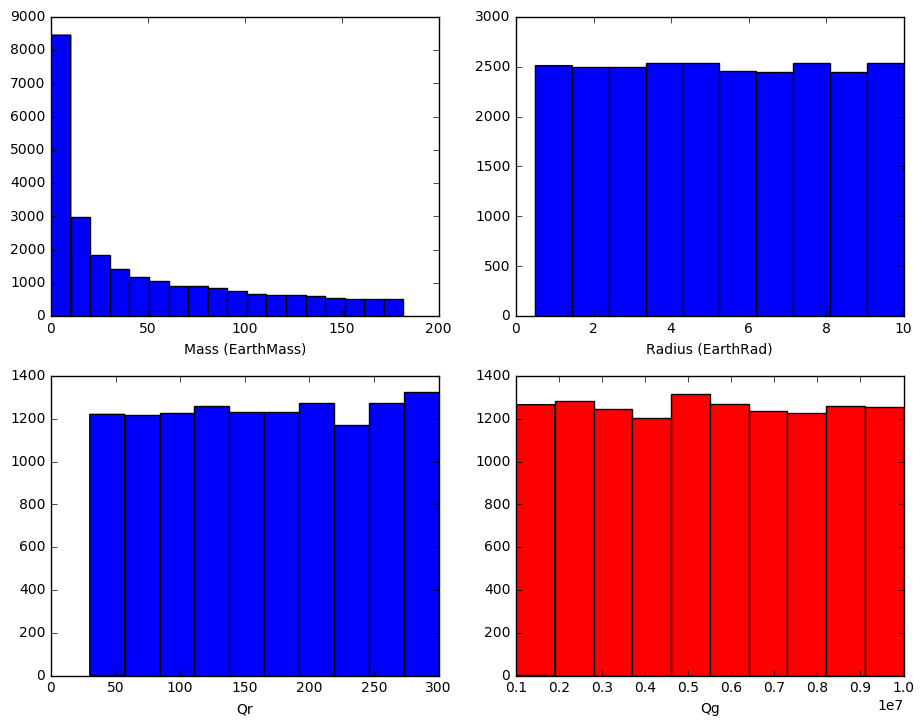

In [22]:
# now to graph above params in histograms
fig,ax = plt.subplots(2,2)
fig.set_size_inches(11,8.5)
ran = max(mass_list)-min(mass_list)
ax[0,0].hist(mass_list,bins=18) # 18 bins --> binwidth ~10 earthMass
ax[0,1].hist(dRadius) # Uniform
q_lower = np.where(Qp<=301)
q_upper = np.where(Qp>301) 
ax[1,0].hist(Qp[q_lower]) 
ax[1,1].hist(Qp[q_upper],color='r')

ax[0,0].set_xlabel('Mass (EarthMass)')
ax[0,1].set_xlabel('Radius (EarthRad)')
ax[1,0].set_xlabel('Qr')
ax[1,1].set_xlabel('Qg')

In [25]:
# Parameters still need to do, by file
# b.in
name_b = 'b'
modules_b = 'eqtide'
sTideModel = 'p2'
dMass = mass_list
dRadius = dRadius
dRotPeriod = -1 #???????????????
dObliquity = 23.5 #?????????????????
dRadGyra = 0.5 #??????????????
dTidalQ = Qp # no related to radius or mass --> low mass, but Qgas? 
dK2 = 0.3 #???????????
dMaxLockDiff = 0.1 #??????????????
saTidePerts = 'star'
saOutputOrder = 'Time Semim Ecce'

#star.in
name_star = 'star'
modules_star = 'eqtide'
dMass_star = np.random.uniform(0.7,1.4,25000)
dRadius_star = dMass_star
dObliquity_star = 0  #???????????
dRotPeriod_star = -83 #????????????
dRadGyra_star = 0.5 #??????????????????/
dTidalQ_star = 10**6
dK2_star = 0.3 #?????????????
saTidePerts_star = 'b'
saOutputOrder = 'Time'

#vpl.in
Sys_name = 'system'
iVerbose = 5
bOverwrite = 1
saBodyFiles = 'b.in star.in'
UnitMass = 'solar' # the units of b_mass?
UnitLength = 'aU' # units of b_radius? 
UnitTime = 'YEARS'
UnitAngle = 'd'
UnitTemp = 'K'
bDoLog = 1
iDigits = 6
dMinValue = 10**(-10)
bDoForward = 1
bVarDt = 1
dEta = 0.01
dStopTime = Ages
dOutputTime = 10**9

[ 0.51528117] =r 
 (array([0, 1, 2, 3]),) =r_mask(indices) 
 [ 0.    0.05  0.1   0.15  0.2 ] bins(last is right edge) 
 4 index of right edge 
    % in bin   
--------------
0.149171270718
0.256906077348
0.417127071823
0.508287292818
0.591160220994


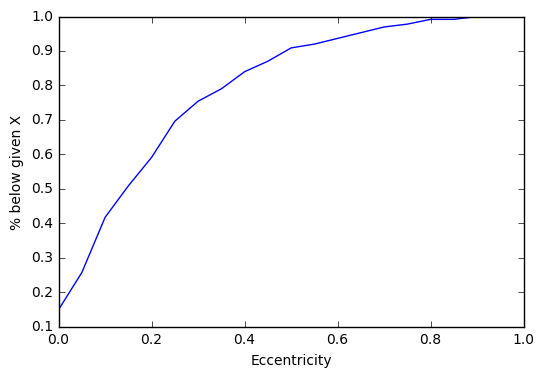

In [2]:

# Sanity check, pick some range of y and spit out x and compare to original 
'''
to create cumdist, need a line where x is 0 to 1 and y is 0 to 1. 
each point is the sum of all the previous points (the third column in the data)
'''
fig,ax=plt.subplots(1,1)
x = np.arange(0,1,0.05)
y = data['cum %']
#y = np.array(y)
ax.plot(x,y,c='blue')
ax.set_xlabel('Eccentricity')
ax.set_ylabel('% below given X')

#sanity check


    
    
r = (np.random.sample(1))
if r >= 0.25 and r <= 0.75:
    r_mask = np.where(y<=r)
else:
    r_mask = np.where(y==y) # doesnt apply any masking, x_below = x
    
x_below = x[r_mask]
x_below = np.append(x_below,x_below[-1]+0.05) # to include the bin in which r belongs
max_index = np.argmax(x_below) 
max_range = x_below[-1]


# now set r = y and find all values of x that are less than that percent
#now add (% in bin) up to b_max, and compare cumsum 
sanity_check = np.cumsum(ecc_inbin[0:max_index+1])
print(r,'=r','\n',r_mask,'=r_mask(indices)','\n',x_below,'bins(last is right edge)','\n',max_index,'index of right edge','\n',sanity_check)

In [3]:
# make 25000 ICs w/ mass, radii, Q, ecc., period and histogram of each; 25 bins per parameter
# in data, the last column is upper bound for the bin, where bin_upper is the next line's eccentricity
    #ex --> first line means 14.9% are below 0.05
#DATA MATCHES!!!!!
#25000 folders
#np.random.uniform() for all except eccentricity.
#import subprocess. 
#size of output files
#output time 1gyr
#eqtide
#ecc + binwidth
    #get bin, then plus random number in binwidth. 

[ 0.02158543  0.11411612  0.52857343 ...,  0.04972211  0.02295736
  0.12872337] (0,)


(array([ 0.14356,  0.1018 ,  0.14672,  0.09544,  0.07888,  0.09484,
         0.06948,  0.04104,  0.04236,  0.03552,  0.03524,  0.02456,
         0.01276,  0.01664,  0.01612,  0.01536,  0.00856,  0.01292,
         0.00028,  0.00792]),
 array([  4.45331527e-06,   4.74722550e-02,   9.49400566e-02,
          1.42407858e-01,   1.89875660e-01,   2.37343462e-01,
          2.84811263e-01,   3.32279065e-01,   3.79746867e-01,
          4.27214668e-01,   4.74682470e-01,   5.22150272e-01,
          5.69618073e-01,   6.17085875e-01,   6.64553677e-01,
          7.12021478e-01,   7.59489280e-01,   8.06957082e-01,
          8.54424883e-01,   9.01892685e-01,   9.49360487e-01]),
 <a list of 20 Patch objects>)

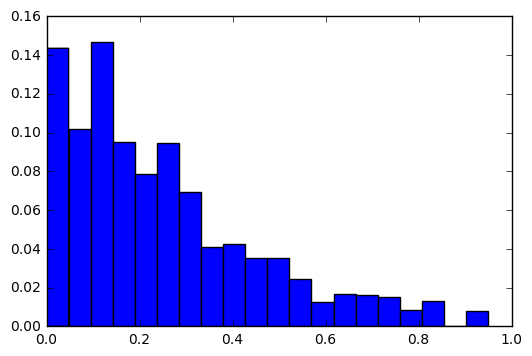

In [4]:
# generate eccentricity distribution mirroring above histogram
from IPython.core.debugger import Tracer
n = 1
ecc_list = np.array([])
while n <= 25000:
    r = (np.random.sample(1)) #some y value (percentage)
    #Tracer()()
    if r <= 0.149171270718232:
        bin_lower=0.0
        bin_upper=0.05
    else:
        r_mask = np.where(y<=r)
        x_below = x[r_mask]
        x_below = np.append(x_below,x_below[-1]+0.05)
        bin_upper = x_below[-1]+0.05
        bin_lower = x_below[-2]+0.05
    rand = np.random.uniform(0,0.05,1)
    ecc = bin_lower + rand 
    ecc_list=np.append(ecc_list,ecc)
    n += 1
    continue
too_big = np.where(x>1)
np.delete(ecc_list,ecc_list[too_big])
print (ecc_list,ecc_list[too_big].shape)
fig,ax = plt.subplots(1,1)
plt.hist(ecc_list,bins=20,weights=np.zeros_like(ecc_list)+1./ecc_list.size)

[ 174.48846602   82.47040396    8.49830037 ...,   23.45126741   40.46563942
    1.25488597] (Unit not initialised) [ 9.86186036  7.68191177  1.78869334 ...,  5.05155843  6.05896918
  1.06363994] earthRad [  5.07942500e+06   2.48994900e+06   2.33000000e+02 ...,   8.30000000e+01
   2.73000000e+02   1.12000000e+02] (25000,) (25000,) (25000,)


In [6]:
#what do i need for simulations: b.in, star.in, vpl.in. only running eqtide, so only eqtide params. Check gl581 to get defined list? 
'''
b.in: Physical Properties
'''

'\nb.in: Physical Properties\n'

[ 13.50747236  19.70285781  43.9193571  ...,  92.39064455  64.96627212
   1.46921839] (Unit not initialised) [ 4.20301852  4.76664727  6.22666162 ...,  7.97834122  7.09467637
  2.00631318] earthRad (75000,) (25000,)


In [96]:

        
    
# generating Qr or Qg

    

[ 177.54837618   14.80036303    7.93758607 ...,    9.62982634  138.72509339
   27.162276  ] (Unit not initialised) [ 9.91917401  4.33305362  3.52046007 ...,  3.75470735  9.13597598
  5.30508068] earthRad


In [101]:
#tests for correlation between dRadius and Masses: GOOD!


t=(4.333 * u.earthRad) #r > 2
t.to(u.cm)
volume = (4 * np.pi * t**3)/3
density = (1*u.g)/(1*u.cm)**3
mass = volume * density
mass = mass.to(u.earthMass)

y = (0.5184273 * u.earthRad) # r < 2
#mass = (y/const.R_earth)**(3.68)*const.M_earth
#mass=mass.to(u.earthMass)
mass

<Quantity 14.799813582748513 earthMass>

In [129]:
# generating Qr or Qg
from random import choice
Qp=np.array([])
for _ in range(20):
    Qr = np.random.randint(30,301)
    Qg = np.random.randint(10**6,(10**7)+1)
    Qq = choice([Qr,Qg])
    Qp = np.append(Qp,Qq)
print (Qp)

[  3.97840700e+06   9.41758600e+06   9.92110800e+06   4.82111500e+06
   1.06000000e+02   2.54000000e+02   9.10000000e+01   9.74143900e+06
   3.83602400e+06   2.65000000e+02   3.60000000e+01   9.15155700e+06
   2.89000000e+02   8.28531700e+06   9.41730700e+06   7.75169600e+06
   2.47000000e+02   2.14381500e+06   4.43565500e+06   2.52970200e+06]
